In [2]:
import torch
import torch.nn as nn

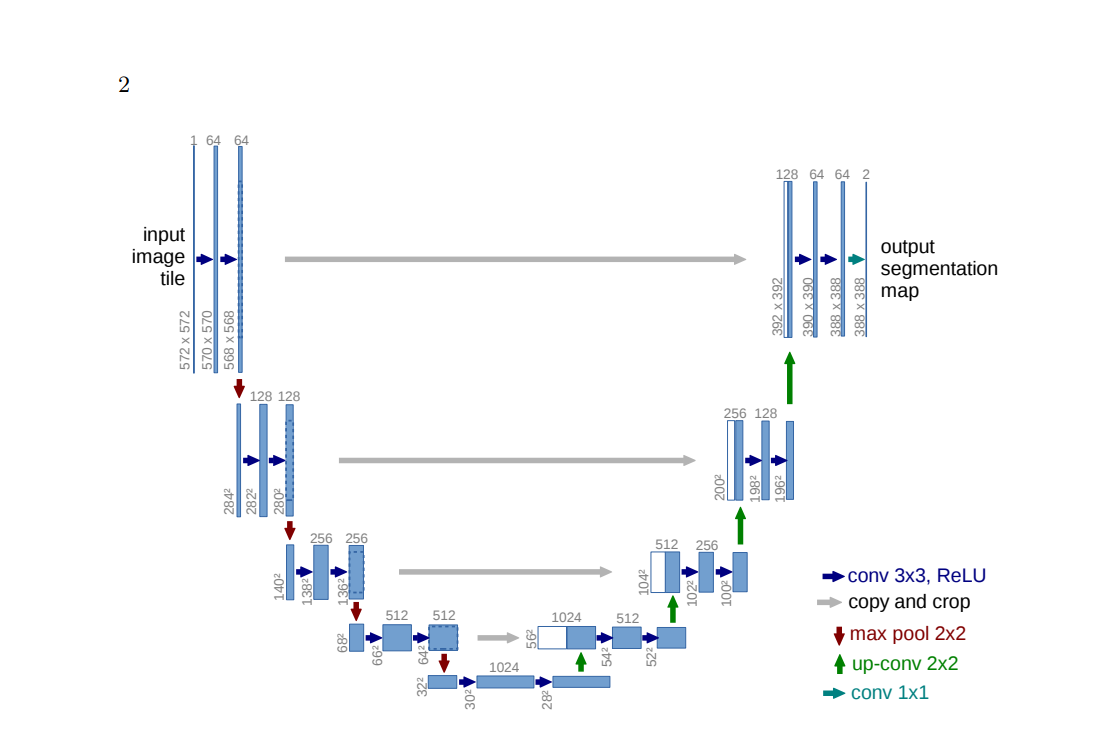

In [14]:
def double_conv(in_c, out_c):
    
    conv = nn.Sequential(
        nn.Conv2d(in_c, out_c, kernel_size=3),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_c, out_c, kernel_size=3),
        nn.ReLU(inplace=True),
    )
    return conv

# crop

def crop_img(tensor, target_tensor):
    target_size = target_tensor.size()[2]
    tensor_size = tensor.size()[2]
    delta = tensor_size - target_size
    delta = delta // 2

    return tensor[:, :, delta:tensor_size-delta, delta:tensor_size - delta]
                                     


In [22]:
class Unet(nn.Module):
    def __init__(self):
        super(Unet, self).__init__()

        self.max_pool_2x2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.down_conv_1 = double_conv(1, 64)
        self.down_conv_2 = double_conv(64, 128)
        self.down_conv_3 = double_conv(128, 256)
        self.down_conv_4 = double_conv(256, 512)
        self.down_conv_5 = double_conv(512, 1024)
        
        self.up_trans_1 = nn.ConvTranspose2d(in_channels=1024,
                                             out_channels=512,
                                            kernel_size=2, 
                                            stride=2)
        
        self.up_conv_1 = double_conv(1024, 512)
        
        self.up_trans_2 = nn.ConvTranspose2d(in_channels=512,
                                             out_channels=256,
                                            kernel_size=2, 
                                            stride=2)
        
        self.up_conv_2 = double_conv(512, 256)
        
        self.up_trans_3 = nn.ConvTranspose2d(in_channels=256,
                                             out_channels=128,
                                            kernel_size=2, 
                                            stride=2)
        
        self.up_conv_3 = double_conv(256, 128)
        
        self.up_trans_4 = nn.ConvTranspose2d(in_channels=128,
                                             out_channels=64,
                                            kernel_size=2, 
                                            stride=2)
        
        self.up_conv_4 = double_conv(128, 64)
        
        self.out = nn.Conv2d(
            in_channels=64,
            out_channels=2,
            kernel_size=1
        )
        
    def forward(self, image):
        # batch size , c , h , w
        # encoder 
        x1 = self.down_conv_1(image) # 
        x2 = self.max_pool_2x2(x1)
        x3 = self.down_conv_2(x2) # 
        x4 = self.max_pool_2x2(x3)
        x5 = self.down_conv_3(x4) # 
        x6 = self.max_pool_2x2(x5)
        x7 = self.down_conv_4(x6) #  
        x8 = self.max_pool_2x2(x7)
        x9 = self.down_conv_5(x8)
        
        # decoder
        x = self.up_trans_1(x9)
        y = crop_img(x7,x)
        x = self.up_conv_1(torch.cat([x, y] , 1))
        
        x = self.up_trans_2(x)
        y = crop_img(x5,x)
        x = self.up_conv_2(torch.cat([x, y] , 1))
        
        x = self.up_trans_3(x)
        y = crop_img(x3,x)
        x = self.up_conv_3(torch.cat([x, y] , 1))
        
        x = self.up_trans_4(x)
        y = crop_img(x1,x)
        x = self.up_conv_4(torch.cat([x, y] , 1))
        
        x = self.out(x)
        
        print(x.size())
        return x
        
if __name__ == "__main__":
    image = torch.rand((1, 1, 572, 572))
    model = Unet()
    print(model(image))

torch.Size([1, 2, 388, 388])
tensor([[[[-0.1227, -0.1177, -0.1239,  ..., -0.1273, -0.1257, -0.1255],
          [-0.1242, -0.1246, -0.1224,  ..., -0.1273, -0.1243, -0.1267],
          [-0.1234, -0.1198, -0.1256,  ..., -0.1268, -0.1260, -0.1237],
          ...,
          [-0.1247, -0.1215, -0.1247,  ..., -0.1274, -0.1263, -0.1238],
          [-0.1255, -0.1255, -0.1307,  ..., -0.1232, -0.1301, -0.1278],
          [-0.1275, -0.1250, -0.1230,  ..., -0.1255, -0.1322, -0.1238]],

         [[ 0.0919,  0.0873,  0.0881,  ...,  0.0839,  0.0904,  0.0875],
          [ 0.0858,  0.0858,  0.0885,  ...,  0.0851,  0.0823,  0.0869],
          [ 0.0916,  0.0910,  0.0881,  ...,  0.0861,  0.0886,  0.0841],
          ...,
          [ 0.0860,  0.0859,  0.0829,  ...,  0.0820,  0.0890,  0.0815],
          [ 0.0878,  0.0903,  0.0908,  ...,  0.0855,  0.0880,  0.0800],
          [ 0.0850,  0.0856,  0.0861,  ...,  0.0889,  0.0880,  0.0870]]]],
       grad_fn=<ConvolutionBackward0>)
